In [1]:
import sys
path_to_pip_installs = "/tmp/test_env"
if path_to_pip_installs not in sys.path:
    sys.path.insert(0, path_to_pip_installs)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import torch
import os
from torch.utils.data import DataLoader
from pytorch_dataset import HDF5ContrastDataset

## Helper Functions

Slices should be available for all contrasts

In [4]:
def load_dataset(base_path, contrast, image_type, cfg_transform, split="train", image_dim=0):
    # Load the synthetic dataset
    cfg_filters = {
        "contrast__in": [contrast],
        "non_zero": True,
        "image_dim": 0,
        "image_type": image_type,
        "split":split,
    }
    dataset = HDF5ContrastDataset(
        hdf5_path=f"{base_path}/data_{contrast}.h5",
        filter=cfg_filters,
        transform=cfg_transform,
        stage="eval",  
    )
    return dataset


def get_all_slices(dataset, contrast):
    for i in range(len(dataset)):
        sample = dataset[i]
        subject_id = sample["metadata"]['patient_id']
        z_dim = sample["metadata"]['z_dim']
        slice_dataframe.loc[len(slice_dataframe)] = [contrast, subject_id, z_dim]
    return slice_dataframe

def create_valid_slice_df(dict_of_dataset):
    slice_dataframe = pd.DataFrame(columns=["contrast", "patient_id", "z_dim"])

    for contrast_key, dataset in dict_of_dataset.items():
        for i in range(len(dataset)):
            sample = dataset[i]
            subject_id = sample["metadata"]['patient_id']
            z_dim = sample["metadata"]['z_dim']
            slice_dataframe.loc[len(slice_dataframe)] = [contrast_key, subject_id, z_dim]

    num_contrasts = len(slice_dataframe["contrast"].unique())

    display(slice_dataframe.groupby("contrast")[["patient_id"]].count())

    slice_df = slice_dataframe.groupby(["patient_id", "z_dim"])[["contrast"]].agg(lambda x: len(x.to_list())).reset_index()

    valid_slices_df = slice_df[slice_df["contrast"]==num_contrasts].reset_index(drop=True)
    print(f"Number of valid slices with all contrasts: {len(valid_slices_df)}")
    return valid_slices_df


In [5]:
def get_relevant_slice(dataset, patient_id, z_dim):
    for i in range(len(dataset)):
        sample = dataset[i]
        subject_id = sample["metadata"]['patient_id']
        slice_z_dim = sample["metadata"]['z_dim']
        if subject_id == patient_id and slice_z_dim == z_dim:
            return sample
    return None

def get_relevant_slice_image(dataset, patient_id, z_dim):
    sample = get_relevant_slice(dataset, patient_id, z_dim)
    if sample is not None:
        return sample["image"].squeeze().numpy()
    else:
        return None

def normalize(image):
    """Basic min max scaler.
    """
    min_ = np.min(image)
    max_ = np.max(image)
    scale = max_ - min_
    image = (image - min_) / scale
    return image



def irm_min_max_preprocess(image, low_perc=1, high_perc=99):
    """Main pre-processing function used for the challenge (seems to work the best).

    Remove outliers voxels first, then min-max scale.

    Warnings
    --------
    This will not do it channel wise!!
    """

    non_zeros = image > 0
    low, high = np.percentile(image[non_zeros], [low_perc, high_perc])
    image = np.clip(image, low, high)
    image = normalize(image)
    return image

def build_numpy_dataset(valid_slices_df, dataset, , normalize=False):
    data_array = []
    for i in range(len(valid_slices_df)):
        patient_id = valid_slices_df.loc[i, "patient_id"]
        z_dim = valid_slices_df.loc[i, "z_dim"]

        image = get_relevant_slice_image(dataset, patient_id, z_dim)
        if image is None:
            print(f"Warning: No image found for patient {patient_id} at slice {z_dim}")
            continue
        data_array.append(image)
    assert len(data_array) == len(valid_slices_df), "Mismatch in number of slices and data array length"
    data_array = np.array(data_array)
    if normalize:
        data_array = irm_min_max_preprocess(data_array)
    return data_array

SyntaxError: invalid syntax (1802520910.py, line 44)

In [ ]:
def create_dataset(contrast_dict, cfg_transform, base_path, save_path, split="test", normalize=False):

    # Create split directory if it doesn't exist
    os.makedirs(f"{save_path}/{split}", exist_ok=True)

    # 1. Load datasets
    dataset_dict = {}
    for contrast_key, img_type in contrast_dict.items():
        dataset_dict[contrast_key] = load_dataset(base_path, contrast_key, img_type, cfg_transform, split=split, image_dim=0)

    # 2. Create valid slice dataframe
    valid_slices_df = create_valid_slice_df(dataset_dict)

    # 3. Build numpy datasets for each contrast
    for contrast_key, dataset in dataset_dict.items():
        numpy_data = build_numpy_dataset(valid_slices_df, dataset, normalize=normalize)
        print(f"Numpy data shape for {contrast_key}: {numpy_data.shape}")
        np.save(f"{save_path}/{split}/{contrast_key}.npy", numpy_data)

        
        

## Create dataset with own normalization

In [52]:
cfg_transform = {
  "eval": [
    {
      "GroupMinMaxNormalize": {
        "stats_path": "/home/students/studweilc1/SynthRegGAN/data/minmax_values.json"
      }
    },

  ]
}

base_path = "/home/students/studweilc1/SynthRegGAN/data"
save_path = "/home/students/studweilc1/MU-Diff/data/my_data"

contrast_dict = {
    "DIXON": "W",
    "T1_mapping_fl2d": "s",
    "Diffusion": "TRACEW",
    "BOLD": "s"
}

In [69]:
create_dataset(contrast_dict, cfg_transform, base_path, save_path, split="test")

Loaded normalization stats for 6 contrasts.
Loaded normalization stats for 6 contrasts.
Loaded normalization stats for 6 contrasts.
Loaded normalization stats for 6 contrasts.


,patient_id
contrast,
BOLD,118
DIXON,149
Diffusion,162
T1_mapping_fl2d,139


Number of valid slices with all contrasts: 102
Numpy data shape for DIXON: (102, 256, 256)
Numpy data shape for T1_mapping_fl2d: (102, 256, 256)
Numpy data shape for Diffusion: (102, 256, 256)
Numpy data shape for BOLD: (102, 256, 256)


In [74]:
create_dataset(contrast_dict, cfg_transform, base_path, save_path, split="val")

Loaded normalization stats for 6 contrasts.
Loaded normalization stats for 6 contrasts.
Loaded normalization stats for 6 contrasts.
Loaded normalization stats for 6 contrasts.


,patient_id
contrast,
BOLD,120
DIXON,137
Diffusion,151
T1_mapping_fl2d,135


Number of valid slices with all contrasts: 71
Numpy data shape for DIXON: (71, 256, 256)
Numpy data shape for T1_mapping_fl2d: (71, 256, 256)
Numpy data shape for Diffusion: (71, 256, 256)
Numpy data shape for BOLD: (71, 256, 256)


In [ ]:
create_dataset(contrast_dict, cfg_transform, base_path, save_path, split="train")

Loaded normalization stats for 6 contrasts.
Loaded normalization stats for 6 contrasts.
Loaded normalization stats for 6 contrasts.
Loaded normalization stats for 6 contrasts.


,patient_id
contrast,
BOLD,1086
DIXON,1180
Diffusion,1217
T1_mapping_fl2d,1188


Number of valid slices with all contrasts: 950
Numpy data shape for DIXON: (950, 256, 256)


## Create dataset with MU normalization

In [ ]:
cfg_transform_mu = None

base_path = "/home/students/studweilc1/SynthRegGAN/data"
save_path_mu = "/home/students/studweilc1/MU-Diff/data/my_data_mu_norm"

contrast_dict = {
    "DIXON": "W",
    "T1_mapping_fl2d": "s",
    "Diffusion": "TRACEW",
    "BOLD": "s"
}

In [ ]:
create_dataset(contrast_dict, cfg_transform_mu, base_path, save_path_mu, split="test")

## Check if data is saved correctly

In [9]:
save_path = "data/my_data"
data_dixon = np.load(f"{save_path}/train/DIXON.npy")
data_t1 = np.load(f"{save_path}/train/T1_mapping_fl2d.npy")
data_diffusion = np.load(f"{save_path}/train/Diffusion.npy")
data_bold = np.load(f"{save_path}/train/BOLD.npy")

print("Data shapes:")
print(f"DIXON: {data_dixon.shape}")
print(f"T1_mapping_fl2d: {data_t1.shape}")
print(f"Diffusion: {data_diffusion.shape}")
print(f"BOLD: {data_bold.shape}")

Data shapes:
DIXON: (950, 256, 256)
T1_mapping_fl2d: (950, 256, 256)
Diffusion: (950, 256, 256)
BOLD: (950, 256, 256)


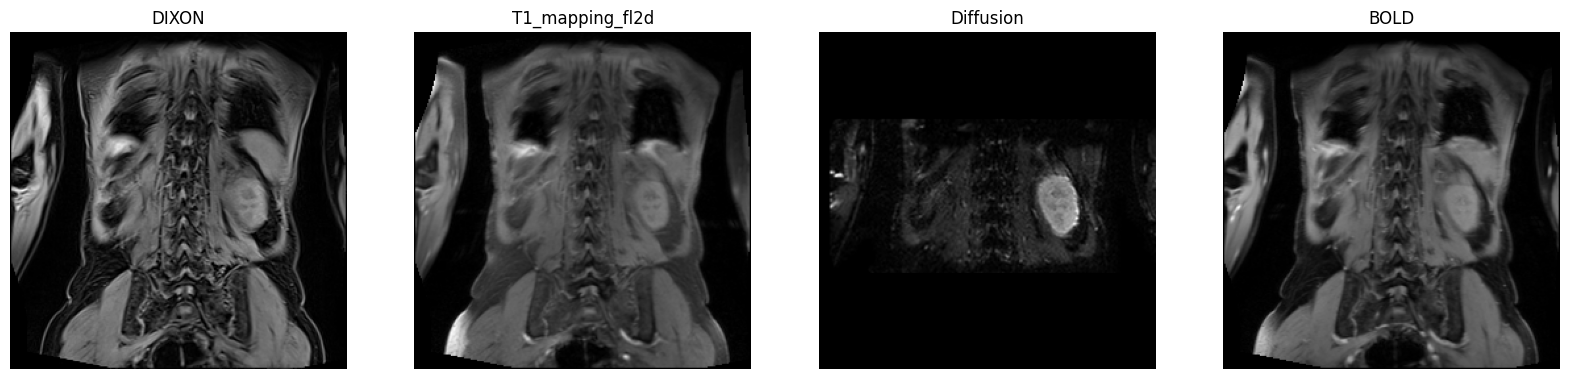

In [7]:
index = 101

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(data_dixon[index], cmap='gray')
axs[0].set_title('DIXON')
axs[1].imshow(data_t1[index], cmap='gray')
axs[1].set_title('T1_mapping_fl2d')
axs[2].imshow(data_diffusion[index], cmap='gray')
axs[2].set_title('Diffusion')
axs[3].imshow(data_bold[index], cmap='gray')
axs[3].set_title('BOLD')

for a in axs:
    a.axis('off')
plt.show()

In [10]:
from dataset_dixon import CreateDatasetSynthesis
dataset = CreateDatasetSynthesis(phase="train", input_path="data/my_data")

padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0


In [11]:
len(dataset)

950

In [14]:
train_sampler = torch.utils.data.distributed.DistributedSampler(dataset,
                                                                num_replicas=3,
                                                                rank=0)
data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=4,
                                            pin_memory=True,
                                            sampler=train_sampler,
                                            drop_last=True)

In [15]:
print('train data size:' + str(len(data_loader)))

train data size:317
